In [15]:

import torch
import time
from pprint import pprint
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import statistics
from matplotlib import animation
from scipy.signal import correlate2d
from scipy.signal import convolve2d

torch.manual_seed(42)
np.random.seed(42)

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')
#-------------------------------------------------------------------------------------------
# New Code
#-------------------------------------------------------------------------------------------
def probability_of_fire_array_random(size = 50):

    random_tensor = torch.rand(size)
    numpy_array = random_tensor.numpy()
    
    return numpy_array  



#-------------------------------------------------------------------------------------------
# Code taken from lab 7 
#-------------------------------------------------------------------------------------------
tab20_mod = matplotlib.colormaps['tab20']
tab20_mod.colors = ((1,1,1,1), *tab20_mod.colors[1:])
#LAB 7 ------------------
def plot_2d_array(array, axes=None, title='', cmap=tab20_mod, **options):
    """
    Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue.

    :param axes: the axes to plot on, or None to use the `plt.gca()` (current axes)
    :param options: keyword arguments passed directly to `plt.imshow()`
           see https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html
    """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    # Turn off axes labels and tick marks
    axes.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False ,
                     labelbottom=False, labeltop=False, labelleft=False, labelright=False,)
    # Defaults for displaying a "matrix" with hard-pixel boundaries and (0,0) at top-left
    options = {**dict(interpolation='nearest', origin='upper'), **options}
    axes.imshow(array, cmap=cmap, **options)


#-------------------------------------------------------------------------------------------
# Forest Fire Code // Slightly Edited
#-------------------------------------------------------------------------------------------

class ForestFire:
    """ 2D Cellular Automaton that simulates a fire-dominated landscape """

    # Define names for the 3 possible cell states
    EMPTY = 0
    OCCUPIED = 1

    #Code from Chat-GPT
    FIRE = 2

    # Define a colour map that maps each cell state to an intuitive colour.
    cmap = [(1, 0.5, 0), (0, 1, 0), (1, 0, 0)]
    cmap[EMPTY] = (1, 0.5, 0)  # brown
    cmap[OCCUPIED] = (0, 1, 0)  # green
    cmap[FIRE] = (1, 0, 0)  # red
    forest_colour_map = matplotlib.colors.ListedColormap(cmap)

    # TODO: define a sensible correlation kernel to detect cardinal neighbourhood on fire
    # Edited to conform with Chat-GPT's answer
    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])


#-------------------------------------------------------------------------------------------
# Forest Fire INIT Code
#-------------------------------------------------------------------------------------------
    #n=0 might be problematic
    def __init__(self, n=50, p=0.01, f=0.001, q=0.5, probability = probability_of_fire_array_random((50,50))):
        """Initializes the model.

        n: number of rows
        p: probability an empty cells becomes "forested" (occupied)
        f: probability of spontaneous file (e.g., 1/fire ignition interval)
        q: initial forest density (probability cell is "forested" in initial state)
        """
        self.p = p
        self.f = f
        
        #Code from Chat-GPT
        self.n = n

        # initialize landscape with approx. q proportion of cells OCCUPIED
        self.state = np.random.choice([self.OCCUPIED, self.EMPTY], (n, n), p=[q, 1 - q])
        
        
        self.probability = probability


    def recreate_world(self, matrix):
        self.state = matrix


    def update_probabiltiy(self, matrix):
        self.probability = matrix


    def find_probabiltiy(self):
        return self.probability


    def step(self):
        """Executes one time step, applying the CA rules to regenerate and burn forest."""
        # TODO: define the rules for the CA.  This is a significant challenge b/c there are 4 rules and they must act independently!
        # Tips: develop 1 rule at a time, in the order above, leaving fire spread (correlation) till last.
        #       Compute each rule in 2 steps: (1) identify which cells the rule applies to; (2) update those cells.
        #       Use the next code block, below, to test as you go.


        # Temporary state to calculate changes without affecting the original state during iteration
        # Create from Chat-GPT
        next_state = self.state.copy()


        # Rule 1: Empty to Occupied
        # Create from Chat-GPT (& --> and)
        prob_p = np.random.random(self.state.shape)#*****
        next_state[(self.state == self.EMPTY) & (prob_p < self.p)] = self.OCCUPIED#******

        # Rule 2: Spontaneous Combustion
        # Create from Chat-GPT
        prob_f = np.random.random(self.state.shape)#*****
        next_state[(self.state == self.OCCUPIED) & (prob_f < self.f)] = self.FIRE#*****
        
        
        #* probability_of_fire(self.incline_array, self.normalized_humidity)
        # Rule 3: Burning cells turn to EMPTY
        # Create from Chat-GPT
        next_state[self.state == self.FIRE] = self.EMPTY#****

        # Rule 4: Spread of Fire
        # Use correlate2d to find cells that are adjacent to fire
        # Create from Chat-GPT
        fire_spread = correlate2d(self.state == self.FIRE, self.kernel, mode='same', boundary='wrap') > 0. #*****
        
        can_burn = (self.state == self.OCCUPIED) & fire_spread
        
        will_burn = (can_burn * self.probability >=  probability_of_fire_array_random(size = 50))# probabilkity 
        
        #needs to be edited
        
        next_state[will_burn] = self.FIRE #****
        
        

        # Update the state
        # Create from Chat-GPT
        self.state = next_state 

    def num_occupied(self):
        """ return the number of cells occupied by forest """

        #Created from Chat-GPT
        return np.sum(self.state == self.OCCUPIED)# TODO: count the number of forested cells.


    def pct_occupied(self):
        """ return the proportion of cells occupied by forest """
        return self.num_occupied() / self.state.size


    def draw(self, axes=None, step=''):
        """Draws the CA cells using the forest colour map so values are coloured intuitively."""
        axes = axes or plt.gca()
        title = f'Time:{step} Occupied: {round(self.pct_occupied() * 100, 2)}%'
        plot_2d_array(self.state, axes=axes, title=title,
                      cmap=self.forest_colour_map, vmin=0, vmax=len(self.forest_colour_map.colors))
        
        #from Chat GPT
    def run_until_steady_state(self, max_steps=1000, steady_state_threshold=0.01, tracking_interval=10):
        """Runs the model until it reaches a steady state or the maximum number of steps."""
        forested_cells_history = [self.num_occupied()]
        for step in range(max_steps):
            self.step()
            if step % tracking_interval == 0:
                current_forested = self.num_occupied()
                forested_cells_history.append(current_forested)
                # Check for steady state over the last few steps
                if len(forested_cells_history) > 5:  # Ensure we have enough points to compare
                    recent_changes = [abs(forested_cells_history[i] - forested_cells_history[i-1]) for i in range(-5, 0)]
                    if max(recent_changes) < steady_state_threshold * self.n * self.n:
                        #print(f"Steady state detected at step {step}")
                        return forested_cells_history
        return forested_cells_history

#-------------------------------------------------------------------------------------------
# Animeation Code
#-------------------------------------------------------------------------------------------

class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass



#-------------------------------------------------------------------------------------------
# Prior code taken from lab 7
#-------------------------------------------------------------------------------------------






Now that you have an enhanced model, you need to think about what questions you can answer about how this changes the behaviour.  You will do this by: 

(1) figuring out a way to capture the aspect of "fire behaviour" you feel is important.  We have been using % occupied as a proxy for fire size, which I suspect will still work.

(2) designing a graphical representation of that behaviour.   We have been using % occupied over time.  Again, I think this will still work for you.

(3) design some experimental setups that answer your questions.  For example,  how does the model where your probability landscape is purely random compare with one where it is all ones?    How does that change if the probabiity range is different (e.g. p values between 0.8 and 1 instead of between 0 and 1).   What if the probability landscape is a gradient (more realistic) instead of randomly distributed in space?   What if the probability landscape is patchy (more realistic) instead of randomly distributed?  etc. etc.   There is a lot of potential to answer some really interesting questions about how the spatial distribution of fire likelihood affects the forest state over time now that you have that modelled.


nice.  so you can also imagine designing some algorithms to define different types of probability landscapes.  Some will be simple (e.g., np.ones), others may require a little custom code to create.  But notice the way you set this up, defining the landscape is independent of the fire model itself.  That is crucial because it allows us to develop and think about these 2 parts of the code independently.  That general technique is called "separation of concerns" and it is one of the most fundamental principles for managing software complexity.

In [16]:
#-------------------------------------------------------------------------------------------
# Landscape Functions
#-------------------------------------------------------------------------------------------
class Landscape():
    
    @staticmethod
    def sigmoid (matrix):
        
        sigmoid = lambda x: 1 / (1 + np.exp(-x))
        return sigmoid(matrix)

    @staticmethod
    def convolution (matrix, kernel): 
        #Explination/Info
        #https://www.youtube.com/watch?v=KuXjwB4LzSA&t=957s
        
        return convolve2d(matrix, kernel, mode='valid')
    
    @staticmethod
    def new_world_random (size = 50):

        random_tensor = torch.rand(size)
        numpy_array = random_tensor.numpy()
        
        return numpy_array
    
    @staticmethod
    def new_world (size = 50, value = 0.85):
        
        return np.full((size, size), value)
    
    @staticmethod
    def edit_world(matrix_a, matrix_b, top_left_position = (0,0)):
        
        #From Chat GPT
        rows_a, cols_a = matrix_a.shape
        rows_b, cols_b = matrix_b.shape
        start_row, start_col = top_left_position
        if start_row + rows_b > rows_a or start_col + cols_b > cols_a:
            raise ValueError("Matrix B does not fit within Matrix A at the given position.")
        matrix_main = np.copy(matrix_a)
        matrix_main[start_row:start_row+rows_b, start_col:start_col+cols_b] = matrix_b
        
        return matrix_main
    
    @staticmethod
    def world_vision (new_forest_fire, frames = 1):
        
        anim= Animation2D(new_forest_fire, frames, steps_per_frame=1, figsize=(5, 5))
        anim.show()
        
    @staticmethod
    def multiply(list):
        for i in list:
            i = 1
            result = result * i
        return result
    
    @staticmethod
    def simulation_graph(n=30, n_steps = 100):
        worlds_occupited_list = []
        world_probabilities_list = []
        for probability_of_fire in range(10):
            current_averges = []
            world_p = Landscape.new_world(50, round(probability_of_fire/10 +0.1, 2))
            for i in range(n):
                
                forest_fire = ForestFire(n=50, p=0.01, f=0.001, q=0.5, probability = world_p)
                
                for _ in range(n_steps):
                    forest_fire.step()
                #forested_history = forest_fire.run_until_steady_state(1000, 0.01, 10)
                current_averges.append(forest_fire.pct_occupied())
                
            worlds_occupited_list.append(statistics.mean(current_averges))
            world_probabilities_list.append(round(probability_of_fire/10 +0.1, 2))
    
        return world_probabilities_list, worlds_occupited_list
    
    @staticmethod
    def graphs(world_probabilities_list, worlds_occupited_list):

        plt.plot( world_probabilities_list, worlds_occupited_list)
        plt.xlabel('Probabilities')
        plt.ylabel('Forested Cells statistic')
        plt.title('Probability of fire vs Forested Cells statistic')
        plt.show()
        

    @staticmethod
    def world_history (world_name):
        forested_history = world_name.run_until_steady_state(1000, 0.01, 10)

        plt.plot(forested_history)
        plt.xlabel('Step')
        plt.ylabel('Forested Cells')
        plt.title('Forested Density')
        plt.show()
        
        print(" Steady state info:", "\n", "Number of forested", world_name.num_occupied(),  "\n", "Amount of forest:", world_name.pct_occupied())
    
    
        


Hypothosis reducing probabilty of the spread of fire results in Orignal fire model would reduce the spread of the fire more in sufficated routs than open routs. 

Hypothosis:
As we reduce the probobility of a nieghboring forest cell of a fire cell, can catch fire the more forest their should be.

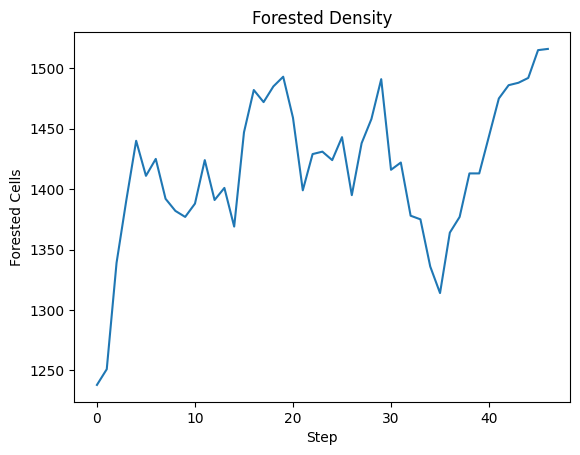

 Steady state info: 
 Number of forested 1516 
 Amount of forest: 0.6064


In [17]:
#-------------------------------------------------------------------------------------------
# Test Space
#-------------------------------------------------------------------------------------------

probability_matrix_of_ones = Landscape.new_world(50, 0.5)

forest_fire = ForestFire(n=50, p=0.01, f=0.001, q=0.5, probability = probability_matrix_of_ones)


Landscape.world_history(forest_fire)



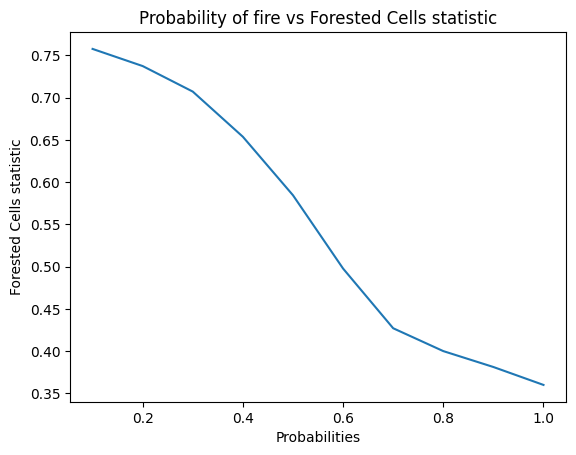

In [18]:
#-------------------------------------------------------------------------------------------
# Test Space
#-------------------------------------------------------------------------------------------
world_probabilities_list, worlds_occupited_list = Landscape.simulation_graph(100)#1m 30s for 1000 on an M1

Landscape.graphs(world_probabilities_list, worlds_occupited_list)


In [19]:
print(world_probabilities_list)
print(worlds_occupited_list)

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
[0.7576080000000001, 0.737324, 0.707116, 0.653676, 0.58448, 0.49774, 0.427116, 0.40008, 0.381272, 0.360064]


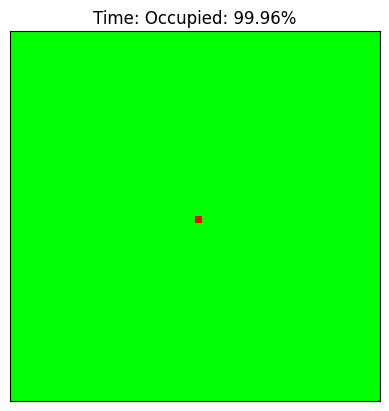

In [20]:
probability_matrix_of_ones = Landscape.new_world(50, 1)# 

one_fire = Landscape.edit_world(probability_matrix_of_ones, np.array([[2]]), (25,25))

probability_matrix_of_ones = Landscape.new_world(50, 1)

forest_fire_all = ForestFire(n=50, p=0.01, f=0.000, q=0.5, probability = probability_matrix_of_ones)

forest_fire_all.recreate_world(one_fire) 

forest_fire_all.draw()

In [21]:
forest_fire_all.update_probabiltiy(Landscape.new_world(50, 0.1)) 

one_fire = Landscape.edit_world(probability_matrix_of_ones, np.array([[2]]), (25,25))

forest_fire_all.recreate_world(one_fire)

animation_one = Animation2D(forest_fire_all, frames = 10, steps_per_frame=1, figsize=(5, 5))

animation_one.show()

In [22]:
forest_fire_all.update_probabiltiy(Landscape.new_world(50, 0.2)) 

one_fire = Landscape.edit_world(probability_matrix_of_ones, np.array([[2]]), (25,25))

forest_fire_all.recreate_world(one_fire)

animation_one = Animation2D(forest_fire_all, frames = 10, steps_per_frame=1, figsize=(5, 5))

animation_one.show()

In [23]:
forest_fire_all.update_probabiltiy(Landscape.new_world(50, 0.3)) #interesting

one_fire = Landscape.edit_world(probability_matrix_of_ones, np.array([[2]]), (25,25))

forest_fire_all.recreate_world(one_fire)

animation_one = Animation2D(forest_fire_all, frames = 10, steps_per_frame=1, figsize=(5, 5))

animation_one.show()

In [24]:
forest_fire_all.update_probabiltiy(Landscape.new_world(50, 0.4)) #interesting

one_fire = Landscape.edit_world(probability_matrix_of_ones, np.array([[2]]), (25,25))

forest_fire_all.recreate_world(one_fire)

animation_one = Animation2D(forest_fire_all, frames = 10, steps_per_frame=1, figsize=(5, 5))

animation_one.show()

In [25]:
forest_fire_all.update_probabiltiy(Landscape.new_world(50, 0.5)) #interesting

one_fire = Landscape.edit_world(probability_matrix_of_ones, np.array([[2]]), (25,25))

forest_fire_all.recreate_world(one_fire)

animation_one = Animation2D(forest_fire_all, frames = 15, steps_per_frame=1, figsize=(5, 5))

animation_one.show()

In [26]:
forest_fire_all.update_probabiltiy(Landscape.new_world(50, 0.7)) #interesting

one_fire = Landscape.edit_world(probability_matrix_of_ones, np.array([[2]]), (25,25))

forest_fire_all.recreate_world(one_fire)

animation_one = Animation2D(forest_fire_all, frames = 60, steps_per_frame=1, figsize=(5, 5))

animation_one.show()

In [27]:
forest_fire_all.update_probabiltiy(Landscape.new_world(50, 0.9)) #interesting

one_fire = Landscape.edit_world(probability_matrix_of_ones, np.array([[2]]), (25,25))

forest_fire_all.recreate_world(one_fire)

animation_one = Animation2D(forest_fire_all, frames = 70, steps_per_frame=1, figsize=(5, 5))

animation_one.show()

In [28]:
forest_fire_all.update_probabiltiy(Landscape.new_world(50, 1)) #interesting

one_fire = Landscape.edit_world(probability_matrix_of_ones, np.array([[2]]), (25,25))

forest_fire_all.recreate_world(one_fire)

animation_one = Animation2D(forest_fire_all, frames = 30, steps_per_frame=1, figsize=(5, 5))

animation_one.show()